In [1]:
#!pip install vector-quantize-pytorch
from vector_quantize_pytorch import VectorQuantize

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
# Load MNIST dataset
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

## Auto Encoder

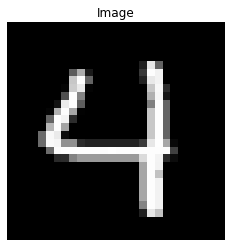

In [4]:
import matplotlib.pyplot as plt

def display_image(image, title='Image'):
    image = image.view(28, 28).cpu().detach().numpy()
    
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

images, _ = next(iter(trainloader))

display_image(images[0])

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class VQVAE2d(nn.Module):
    def __init__(self, channels:int = 1, width=28, height=28, patch_width=7, patch_height=7, hidden_dims=512, bottleneck_dims=2, quantize=False, codebook_size=256):
        super(VQVAE2d, self).__init__()

        self.channels = channels
        self.width = width
        self.height = height
        self.total_size = width * height * channels
        self.patch_width = patch_width
        self.patch_height = patch_height
        self.num_patches_w = width / patch_width
        self.num_patches_h = height / patch_height
        self.total_patches = self.num_patches_w * self.num_patches_h
        self.in_dims = patch_width * patch_height * channels
        self.bottleneck_dims = bottleneck_dims
        self.quantize = quantize
        
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.in_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, bottleneck_dims * 2)

        )

        if self.quantize:
            self.vq = VectorQuantize(
                dim = self.bottleneck_dims * 2,
                codebook_size = codebook_size,     
                decay = 0.8,             
                commitment_weight = 1.
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, self.in_dims),
            nn.Sigmoid()
        )

        self.global_refiner = nn.Sequential(
            nn.Linear(self.total_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, self.total_size),
            nn.Sigmoid()
        )

    def sample(self, x):
        shift = x[:, :self.bottleneck_dims]
        scale = torch.sqrt(torch.exp(x[:, self.bottleneck_dims:]))
        samples = torch.randn_like(shift, device=x.device)
        return shift + samples * scale
    
    @torch.inference_mode()
    def quantized_decode(self, codes):

        # TODO: rewrite to work on arbitrary batch size
        encoded_x = self.vq.codebook[codes]
        
        sampled_x = self.sample(encoded_x)
        decoded_x = self.decoder(sampled_x)
        out = torch.reshape(decoded_x, (1, self.total_size))
        out = torch.reshape(self.global_refiner(out), (1, self.channels, self.width, self.height))

        return out


        
    def forward(self, x):
        
        B, C, W, H = x.shape
        
        patched_x = torch.reshape(x, (int(B * self.total_patches), C, self.patch_width, self.patch_height))
        
        encoded_x = self.encoder(patched_x)
        
        if self.quantize:
            encoded_x, vq_i, vq_l = self.vq(encoded_x)
        
        sampled_x = self.sample(encoded_x)    
        out = torch.reshape(self.decoder(sampled_x), (B, C * W * H))
        out = torch.reshape(self.global_refiner(out), (B, C, W, H))

        return out, vq_i, vq_l if self.quantize else out
        

In [55]:
QUANTIZE = True
NUM_PATCHES = 16
CODEBOOK_SIZE = 32

ae_model = VQVAE2d(hidden_dims=512, bottleneck_dims=2, codebook_size=CODEBOOK_SIZE, quantize=QUANTIZE)
ae_model.to('cuda')

print(count_parameters(ae_model))

criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=1e-4)
epochs = 40

for epoch in range(epochs):
    for data in trainloader:
        img, _ = data
        img = img.to('cuda')
        optimizer.zero_grad()
        if QUANTIZE:
            output, indices, vq_loss = ae_model(img)
        else:
            output = ae_model(img)
        loss = criterion(output, img)
        if QUANTIZE:
            loss += vq_loss.squeeze()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

1646405
Epoch [1/40], Loss: 0.0708
Epoch [2/40], Loss: 0.0671
Epoch [3/40], Loss: 0.0677
Epoch [4/40], Loss: 0.0718
Epoch [5/40], Loss: 0.0574
Epoch [6/40], Loss: 0.0442
Epoch [7/40], Loss: 0.0384
Epoch [8/40], Loss: 0.0365
Epoch [9/40], Loss: 0.0334
Epoch [10/40], Loss: 0.0330
Epoch [11/40], Loss: 0.0301
Epoch [12/40], Loss: 0.0294
Epoch [13/40], Loss: 0.0264
Epoch [14/40], Loss: 0.0270
Epoch [15/40], Loss: 0.0281
Epoch [16/40], Loss: 0.0257
Epoch [17/40], Loss: 0.0250
Epoch [18/40], Loss: 0.0248
Epoch [19/40], Loss: 0.0230
Epoch [20/40], Loss: 0.0236
Epoch [21/40], Loss: 0.0206
Epoch [22/40], Loss: 0.0249
Epoch [23/40], Loss: 0.0221
Epoch [24/40], Loss: 0.0225
Epoch [25/40], Loss: 0.0220
Epoch [26/40], Loss: 0.0229
Epoch [27/40], Loss: 0.0204
Epoch [28/40], Loss: 0.0220
Epoch [29/40], Loss: 0.0208
Epoch [30/40], Loss: 0.0191
Epoch [31/40], Loss: 0.0238
Epoch [32/40], Loss: 0.0230
Epoch [33/40], Loss: 0.0208
Epoch [34/40], Loss: 0.0193
Epoch [35/40], Loss: 0.0178
Epoch [36/40], Loss: 

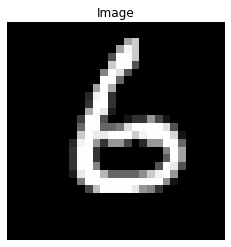

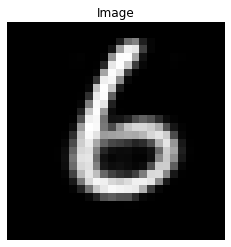

tensor([25, 31,  3,  5,  0, 15, 16, 15, 23, 19, 23, 26, 19, 25, 25, 25],
       device='cuda:0')

In [56]:
i=torch.randint(img.shape[0], (1,))
display_image(img[i].cpu())
if QUANTIZE:
    image, codes, _ = ae_model(img[i])
else:
    image = ae_model(img[i])
display_image(image.cpu())
codes

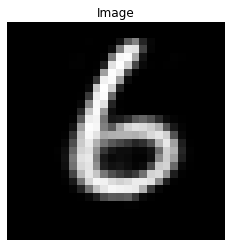

In [57]:
image = ae_model.quantized_decode(codes)
display_image(image.cpu())

## Bayesian Flow Network

In [74]:
class BayesianFlowNetwork(nn.Module):
    """
    Bayesian Flow Network (BFN) model.

    Parameters
    ----------
    D : int, default=2
        Dimensionality of the data.
    K : int, default=2
        Number of classes.
    hidden_dim : int, default=16
        Dimension of the hidden layer.
    """

    def __init__(self, D=2, K=2, hidden_dim=32, beta=3.0):
        super(BayesianFlowNetwork, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K
        # Define the number of output classes based on K
        output_classes = K if K > 2 else 1

        # Define the neural network layers
        self.layer = nn.Sequential(
            nn.Linear(D * K + 1, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, D * output_classes)
        )

    def forward(self, theta, t):
        """
        Forward pass of the Bayesian Flow Network.

        Parameters
        ----------
        theta : torch.Tensor
            Tensor of shape (B, D, K).
        t : torch.Tensor
            Tensor of shape (B,).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (B, D, K).
        """
        theta = (theta * 2) - 1  # scaled in [-1, 1]
        theta = theta.view(theta.shape[0], -1)  # (B, D * K)
        input_ = torch.cat((theta, t.unsqueeze(-1)), dim=-1)
        output = self.layer(input_)  # (B, D * K)
        output = output.view(output.shape[0], self.D, -1)
        return output


    def discrete_output_distribution(self, theta, t):
        """
        Computes the discrete output distribution.

        Algorithm

        Parameters
        ----------
        theta : torch.Tensor
            Input tensor of shape (B, D, K).
        t : torch.Tensor
            Time tensor of shape (B,).

        Returns
        -------
        torch.Tensor
            Output probability tensor. For K=2, shape is (B, D, 2).
            Otherwise, shape is (B, D, K).
        """
        B, D, K = theta.shape

        # Get the forward pass output and reshape
        output = self.forward(theta, t)

        # Check the number of classes and compute the output probabilities accordingly
        if K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x):
        B, D = x.shape

        # Step 1: Sample t from U(0, 1)
        t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)

        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)

        # Step 3: Sample y from N(beta * (K * one_hot(X))
        one_hot_x = F.one_hot(x, num_classes=self.K).float()  # (B, D, K)
        mean = beta[:, None, None] * (self.K * one_hot_x - 1)
        std = (beta * self.K)[:, None, None].sqrt()
        eps = torch.randn_like(mean)
        y = mean + std * eps

        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)

        # Step 5: Calculate the output distribution
        p_0 = self.discrete_output_distribution(theta, t)  # (B, D, K)

        e_x = one_hot_x
        e_hat = p_0  # (B, D, K)
        L_infinity = self.K * self.beta * t[:, None, None] * ((e_x - e_hat) ** 2)
        return L_infinity.mean()

    def sample_with_prompt(self, prompt, batch_size=16, nb_steps=10, device='cpu'):
      one_hot_prompt = F.one_hot(prompt.repeat(batch_size, 1), num_classes=self.K).float()
      # replace any . index with even probability
      random_mask = one_hot_prompt[:, :, 0] == 1
      apply_mask = one_hot_prompt[:, :, 0] != 1
      one_hot_prompt[random_mask] = 1 / self.K
      return self.sample(batch_size=batch_size, theta=one_hot_prompt, apply_mask=apply_mask, nb_steps=nb_steps, device=device)

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=10, theta=None, apply_mask=None, device='cpu'):
        self.eval()

        # get prior
        if theta == None:
          theta = torch.ones((batch_size, self.D, self.K), device=device) / self.K

        for i in range(1, nb_steps+1):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)

            k_probs = self.discrete_output_distribution(theta, t)  # (B, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D)
            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)

            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)

            y = mean + std * eps  # (B, D, K)

            theta_prime = torch.exp(y) * theta
            theta_ = theta_prime / theta_prime.sum(-1, keepdim=True)
            if apply_mask != None:
              theta_[apply_mask] = theta[apply_mask]
            theta = theta_

        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t))
        if apply_mask != None:
            k_probs_final[apply_mask] = theta[apply_mask]
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()

        return k_final

In [75]:
ae_model.train(False)

model = BayesianFlowNetwork(D=NUM_PATCHES, K=CODEBOOK_SIZE, hidden_dim=1024)
model.to('cuda')

print(count_parameters(model))

losses = []

optimizer = optim.Adam(model.parameters())
epochs = 40

ae_model.cpu()


for epoch in range(epochs):
  for data in trainloader:
    model.zero_grad()
    with torch.no_grad():
      img, _ = data
      _, img_codes, _ = ae_model(img)
    
    codes = torch.reshape(img_codes.to('cuda'), (-1, NUM_PATCHES))
    loss = model.process(codes)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
  print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

2100736
Epoch [1/40], Loss: 0.5625
Epoch [2/40], Loss: 0.3268
Epoch [3/40], Loss: 0.1958
Epoch [4/40], Loss: 0.1880
Epoch [5/40], Loss: 0.1388
Epoch [6/40], Loss: 0.1206
Epoch [7/40], Loss: 0.1108
Epoch [8/40], Loss: 0.1211
Epoch [9/40], Loss: 0.0998
Epoch [10/40], Loss: 0.1193
Epoch [11/40], Loss: 0.1235
Epoch [12/40], Loss: 0.0860
Epoch [13/40], Loss: 0.0960
Epoch [14/40], Loss: 0.1058
Epoch [15/40], Loss: 0.0949
Epoch [16/40], Loss: 0.1225
Epoch [17/40], Loss: 0.0991
Epoch [18/40], Loss: 0.1086
Epoch [19/40], Loss: 0.0992
Epoch [20/40], Loss: 0.1018
Epoch [21/40], Loss: 0.1144
Epoch [22/40], Loss: 0.1081
Epoch [23/40], Loss: 0.1127
Epoch [24/40], Loss: 0.0965
Epoch [25/40], Loss: 0.1027
Epoch [26/40], Loss: 0.0891
Epoch [27/40], Loss: 0.0974
Epoch [28/40], Loss: 0.1041
Epoch [29/40], Loss: 0.1154
Epoch [30/40], Loss: 0.1035
Epoch [31/40], Loss: 0.1004
Epoch [32/40], Loss: 0.0789
Epoch [33/40], Loss: 0.0879
Epoch [34/40], Loss: 0.1146
Epoch [35/40], Loss: 0.1390
Epoch [36/40], Loss: 

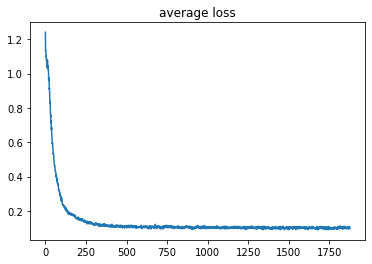

In [76]:
plt.plot(torch.tensor(losses).view(-1, 10).mean(1))
plt.title("average loss");

In [77]:
model = model.cpu()
outputs = model.sample(nb_steps=100).cpu().numpy()
len(output)

96

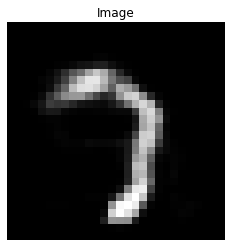

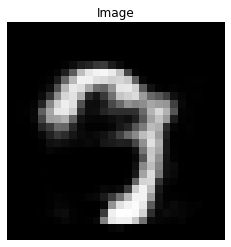

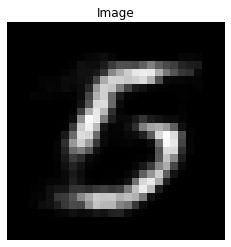

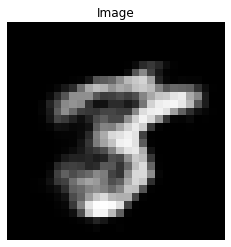

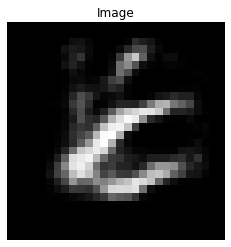

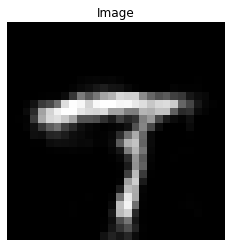

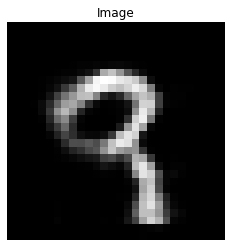

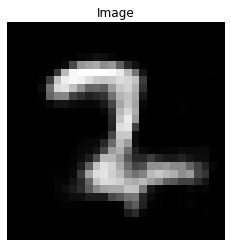

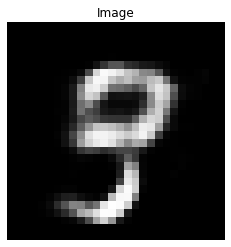

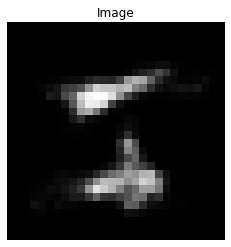

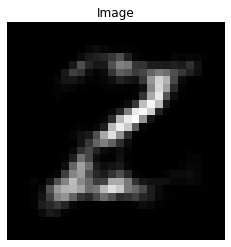

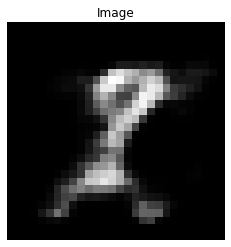

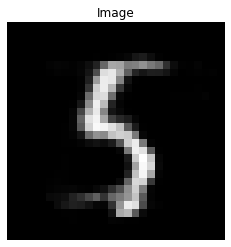

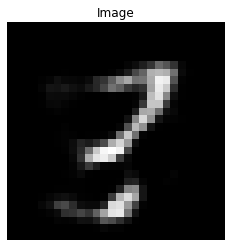

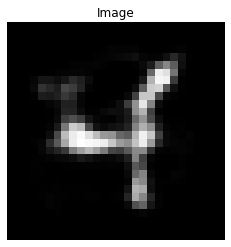

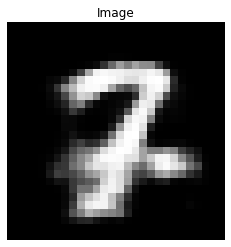

In [78]:
i = 0
for i in range(16):
    image = ae_model.quantized_decode(torch.tensor(outputs[i]))
    display_image(image.cpu())